# Курсовой проект

#### Задача

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

#### Целевая переменная

Credit Default - факт невыполнения кредитных обязательств

#### Метрика качества

F1-score (sklearn.metrics.f1_score)

#### Требования к решению

Целевая метрика

* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)


**Описание датасета**

* **LIMIT_BAL** - Сумма предоставленного кредита
* **SEX** - Пол (1=мужчина, 2=женщина)
* **EDUCATION** - Образование (1=аспирантура, 2=университет, 3=старшая школа, 4=прочее, 5=неизвестно, 6=неизвестно)
* **MARRIAGE** - Семейное положение (1=женат/замужен, 2=не женат/не замуженм, 3=прочее)
* **AGE** - Возраст (в годах)
* **PAY_1** - Статус погашения в Сентябре (-1=погашен полностью, 0=погашен частично, 1=отсрочка платежа на один месяц, .., 3=отсрочка платежа на три месяца и более)
* **PAY_2** - Статус погашения в Августе
* **PAY_3** - Статус погашения в Июле
* **PAY_4** - Статус погашения в Июне
* **PAY_5** - Статус погашения в Мае
* **PAY_6** - Статус погашения в Апреле
* **BILL_AMT1** - Сумма выписки по счету в Сентябре
* **BILL_AMT2** - Сумма выписки по счету в Августе
* **BILL_AMT3** - Сумма выписки по счету в Июле
* **BILL_AMT4** - Сумма выписки по счету в Июне
* **BILL_AMT5** - Сумма выписки по счету в Мае
* **BILL_AMT6** - Сумма выписки по счету в Апреле
* **PAY_AMT1** - Сумма предыдущего платежа в Сентябре
* **PAY_AMT2** - Сумма предыдущего платежа в Августе
* **PAY_AMT3** - Сумма предыдущего платежа в Июле
* **PAY_AMT4** - Сумма предыдущего платежа в Июне
* **PAY_AMT5** - Сумма предыдущего платежа в Мае
* **PAY_AMT6** - Сумма предыдущего платежа в Апреле
* **NEXT_MONTH_DEFAULT** - Просрочка платежа в следующем месяце (1=да, 0=нет)

### Подключение библиотек и скриптов

import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
import xgboost as xgb
import catboost as catb

import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 10})

import numpy as np
import pandas as pd

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 10})

In [842]:
import pandas as pd
import numpy as np
import pickle
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [843]:
import warnings
warnings.simplefilter('ignore')

#### функция вывода метрик

In [847]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

#### функция устранения дисбаланса

In [848]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

### Загрузка данных

In [699]:
# input
#DATASET_PATH = 'files/course_project_test.csv'

# input
DATASET_PATH = 'files/training_project_data.csv'

# output
PREP_DATASET_PATH = 'files/training_project_data_prep.csv'

In [ ]:
# input
DATASET_PATH = '../training_project_data.csv'
PREP_DATASET_PATH = '../training_project_data_prep.csv'

# output
TRAIN_FULL_PATH = '../training_project_train_full.csv'
TRAIN_PART_PATH = '../training_project_train_part_b.csv'
TEST_PART_PATH = '../training_project_test_part.csv'

SCALER_FILE_PATH = '../scaler.pkl'

In [700]:
df = pd.read_csv(DATASET_PATH)
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,NEXT_MONTH_DEFAULT
0,150000.0,2,2,2,24,1,2,0,0,0,...,17853.0,34527.0,28277.0,0.0,2145.0,10000.0,22000.0,3000.0,5093.0,0
1,50000.0,2,3,1,46,3,3,3,3,2,...,30748.0,30162.0,30016.0,0.0,0.0,0.0,0.0,3100.0,798.0,1
2,150000.0,2,2,1,41,-1,-1,-1,-1,0,...,6784.0,6923.0,14116.0,0.0,0.0,6784.0,159.0,167.0,760.0,0
3,150000.0,2,2,2,35,0,0,0,0,0,...,55182.0,48983.0,50136.0,3500.0,2000.0,20000.0,2000.0,2000.0,2000.0,0
4,70000.0,2,1,1,35,1,2,2,2,2,...,47026.0,45971.0,47573.0,0.0,6500.0,1800.0,0.0,2500.0,2000.0,0


### Первичный анализ данных

In [701]:
df.shape

(10000, 24)

In [702]:
df.iloc[0]

LIMIT_BAL             150000.0
SEX                        2.0
EDUCATION                  2.0
MARRIAGE                   2.0
AGE                       24.0
PAY_1                      1.0
PAY_2                      2.0
PAY_3                      0.0
PAY_4                      0.0
PAY_5                      0.0
PAY_6                      0.0
BILL_AMT1              65542.0
BILL_AMT2              28311.0
BILL_AMT3              23978.0
BILL_AMT4              17853.0
BILL_AMT5              34527.0
BILL_AMT6              28277.0
PAY_AMT1                   0.0
PAY_AMT2                2145.0
PAY_AMT3               10000.0
PAY_AMT4               22000.0
PAY_AMT5                3000.0
PAY_AMT6                5093.0
NEXT_MONTH_DEFAULT         0.0
Name: 0, dtype: float64

In [703]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   LIMIT_BAL           10000 non-null  float64
 1   SEX                 10000 non-null  int64  
 2   EDUCATION           10000 non-null  int64  
 3   MARRIAGE            10000 non-null  int64  
 4   AGE                 10000 non-null  int64  
 5   PAY_1               10000 non-null  int64  
 6   PAY_2               10000 non-null  int64  
 7   PAY_3               10000 non-null  int64  
 8   PAY_4               10000 non-null  int64  
 9   PAY_5               10000 non-null  int64  
 10  PAY_6               10000 non-null  int64  
 11  BILL_AMT1           10000 non-null  float64
 12  BILL_AMT2           10000 non-null  float64
 13  BILL_AMT3           10000 non-null  float64
 14  BILL_AMT4           10000 non-null  float64
 15  BILL_AMT5           10000 non-null  float64
 16  BILL_

### Обзор данных

#### Обзор целевой переменной

In [704]:
df['NEXT_MONTH_DEFAULT'].value_counts()

0    7805
1    2195
Name: NEXT_MONTH_DEFAULT, dtype: int64

#### Наблюдается сильный дисбаланс данных.

In [705]:
df.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,NEXT_MONTH_DEFAULT
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,168182.000000,1.606800,1.860000,1.553500,35.39600,0.059200,-0.014600,-0.040800,-0.088100,-0.128900,...,43605.665800,40347.829700,38996.784300,5511.82970,5.931217e+03,5385.050600,4585.585700,4712.134300,5055.019400,0.219500
std,130118.668771,0.488485,0.790482,0.520927,9.19536,0.946248,1.008706,0.984699,0.926944,0.881568,...,65062.788893,61044.676044,59682.999879,14748.85889,2.204220e+04,18527.041096,14066.147593,14080.847065,17359.210922,0.413929
min,10000.000000,1.000000,0.000000,0.000000,21.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-65167.000000,-23003.000000,-339603.000000,0.00000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2400.000000,1703.250000,1300.750000,1000.00000,7.492500e+02,390.000000,277.250000,300.000000,150.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19194.000000,18261.000000,17338.000000,2163.50000,2.001000e+03,1800.000000,1500.000000,1543.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,55731.250000,50491.000000,49696.000000,5001.00000,5.000000e+03,4651.500000,4014.250000,4100.000000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,75.00000,3.000000,3.000000,3.000000,3.000000,3.000000,...,891586.000000,927171.000000,961664.000000,493358.00000,1.227082e+06,896040.000000,432130.000000,417990.000000,422000.000000,1.000000


#### Обзор категориальных признаков

for cat_colname in df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

#### Поиск пропусков

In [707]:
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

LIMIT_BAL - 0%
SEX - 0%
EDUCATION - 0%
MARRIAGE - 0%
AGE - 0%
PAY_1 - 0%
PAY_2 - 0%
PAY_3 - 0%
PAY_4 - 0%
PAY_5 - 0%
PAY_6 - 0%
BILL_AMT1 - 0%
BILL_AMT2 - 0%
BILL_AMT3 - 0%
BILL_AMT4 - 0%
BILL_AMT5 - 0%
BILL_AMT6 - 0%
PAY_AMT1 - 0%
PAY_AMT2 - 0%
PAY_AMT3 - 0%
PAY_AMT4 - 0%
PAY_AMT5 - 0%
PAY_AMT6 - 0%
NEXT_MONTH_DEFAULT - 0%


#### Разделяем количественные и категориальные данные

In [708]:
df_num_features = df.select_dtypes(include=['float64', 'int64'])
df_num_features.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,NEXT_MONTH_DEFAULT
0,150000.0,2,2,2,24,1,2,0,0,0,...,17853.0,34527.0,28277.0,0.0,2145.0,10000.0,22000.0,3000.0,5093.0,0
1,50000.0,2,3,1,46,3,3,3,3,2,...,30748.0,30162.0,30016.0,0.0,0.0,0.0,0.0,3100.0,798.0,1
2,150000.0,2,2,1,41,-1,-1,-1,-1,0,...,6784.0,6923.0,14116.0,0.0,0.0,6784.0,159.0,167.0,760.0,0
3,150000.0,2,2,2,35,0,0,0,0,0,...,55182.0,48983.0,50136.0,3500.0,2000.0,20000.0,2000.0,2000.0,2000.0,0
4,70000.0,2,1,1,35,1,2,2,2,2,...,47026.0,45971.0,47573.0,0.0,6500.0,1800.0,0.0,2500.0,2000.0,0


In [709]:
df_obj_features = df.select_dtypes(include='object')
df_obj_features.head()

""
0
1
2
3
4


### Обработка выбросов

Посторим боксплоты для количественных признаков и оценим наличие выборосов в данных. 

In [710]:
df.loc[df['LIMIT_BAL'] > 525000, 'LIMIT_BAL'] = df['LIMIT_BAL'].median()

<AxesSubplot:>

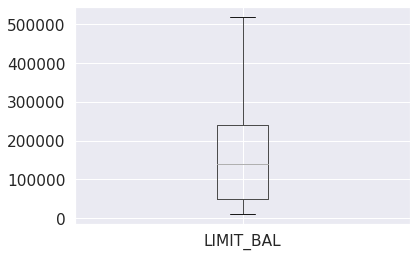

In [711]:
df.boxplot(column='LIMIT_BAL')

<AxesSubplot:>

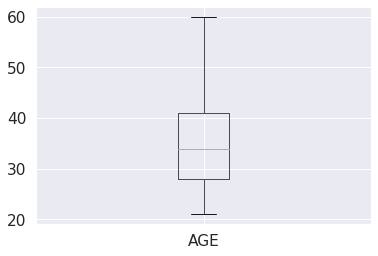

In [712]:
df.loc[df['AGE'] > 60, 'AGE'] = df['AGE'].median()
df.boxplot(column='AGE')

<AxesSubplot:>

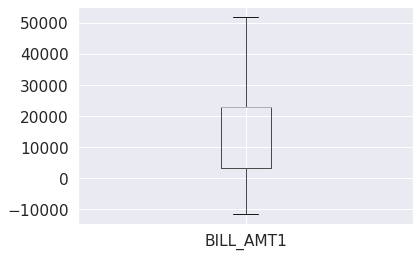

In [713]:
df.loc[df['BILL_AMT1'] > 52000, 'BILL_AMT1'] = df['BILL_AMT1'].median()
df.boxplot(column='BILL_AMT1')

In [714]:
df.loc[df['BILL_AMT2'] > 49000, 'BILL_AMT2'] = df['BILL_AMT2'].median()
#df.boxplot(column='BILL_AMT2')

In [715]:
df.loc[(df['BILL_AMT3'] > 47000) | (df['BILL_AMT3'] < -27000), 'BILL_AMT3'] = df['BILL_AMT3'].median()
#df.boxplot(column='BILL_AMT3')

In [716]:
df.loc[df['BILL_AMT4'] > 44000, 'BILL_AMT4'] = df['BILL_AMT4'].median()
#df.boxplot(column='BILL_AMT4')

In [717]:
df.loc[df['BILL_AMT5'] > 43100, 'BILL_AMT5'] = df['BILL_AMT5'].median()
#df.boxplot(column='BILL_AMT5')

In [718]:
df.loc[(df['BILL_AMT6'] > 41000) | (df['BILL_AMT6'] < -30000), 'BILL_AMT6'] = df['BILL_AMT6'].median()
#df.boxplot(column='BILL_AMT6')

In [719]:
df.loc[df['PAY_AMT1'] > 3900, 'PAY_AMT1'] = df['PAY_AMT1'].median()
#df.boxplot(column='PAY_AMT1')

In [720]:
df.loc[df['PAY_AMT2'] > 3850, 'PAY_AMT2'] = df['PAY_AMT2'].median()
#df.boxplot(column='PAY_AMT2')

In [721]:
df.loc[df['PAY_AMT3'] > 6900, 'PAY_AMT3'] = df['PAY_AMT3'].mean()
#df.boxplot(column='PAY_AMT3')

In [722]:
df.loc[df['PAY_AMT4'] > 7000, 'PAY_AMT4'] = df['PAY_AMT4'].mean()
#df.boxplot(column='PAY_AMT4')

In [723]:
df.loc[df['PAY_AMT5'] > 7000, 'PAY_AMT5'] = df['PAY_AMT5'].mean()
#df.boxplot(column='PAY_AMT5')

In [724]:
df.loc[df['PAY_AMT6'] > 7250, 'PAY_AMT6'] = df['PAY_AMT6'].mean()
#df.boxplot(column='PAY_AMT6')

In [725]:
df.loc[df['EDUCATION'] == '0', 'EDUCATION'] = df['EDUCATION'].mode()[0]

In [726]:
df.loc[df['MARRIAGE'] == '0', 'MARRIAGE'] = df['MARRIAGE'].mode()[0]

In [728]:
for cat_colname in df.select_dtypes(include='object').columns[1:]:
    df = pd.concat([df, pd.get_dummies(df[cat_colname], prefix=cat_colname)], axis=1)

In [729]:
df['ID'] = df.index.tolist()

### Выделение целевой переменной и групп признаков

In [875]:
TARGET_NAME = 'NEXT_MONTH_DEFAULT'
BASE_FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

### Анализ целевой переменной

In [731]:
df[TARGET_NAME].value_counts()

0    7805
1    2195
Name: NEXT_MONTH_DEFAULT, dtype: int64

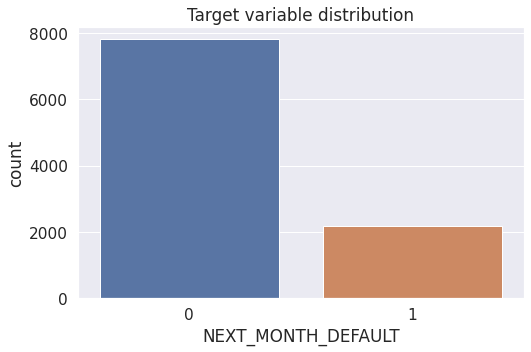

In [732]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df)

plt.title('Target variable distribution')
plt.show()

#### Корреляция с базовыми признаками


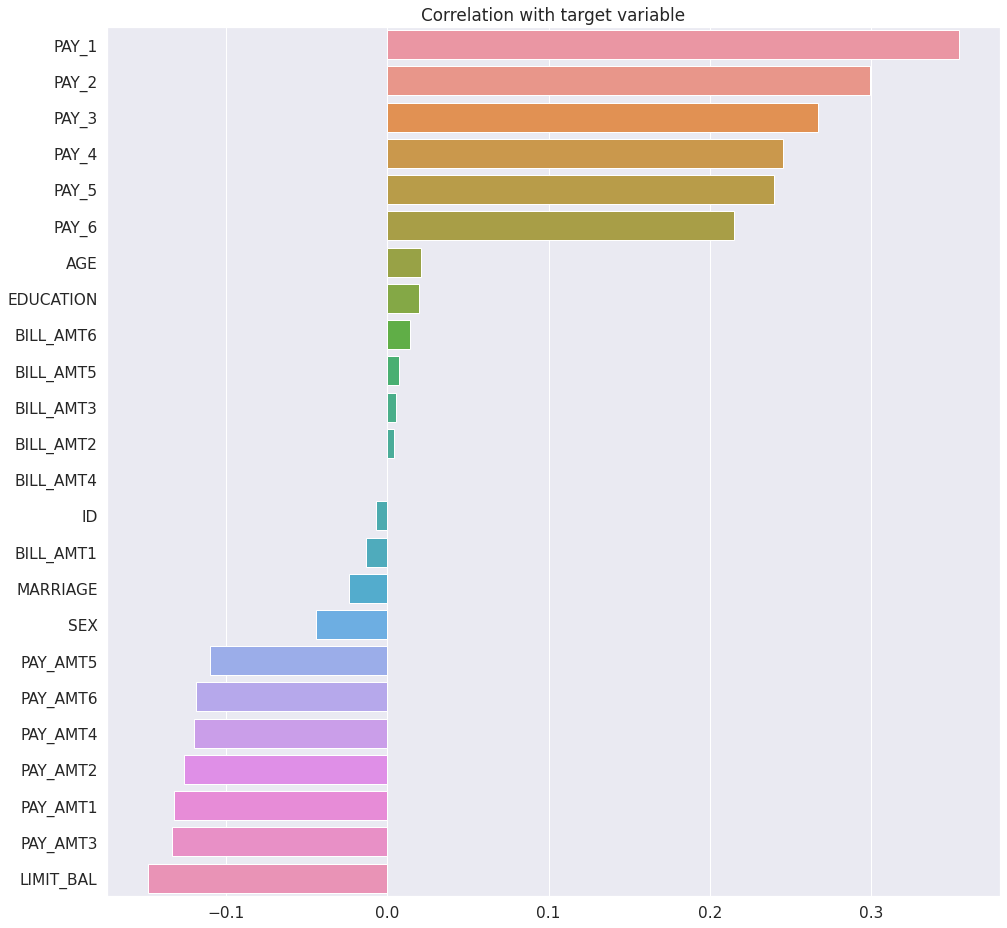

In [733]:
corr_with_target = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(16, 16))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

**Оценка признака "PAY_1" в разрезе целевой переменной**

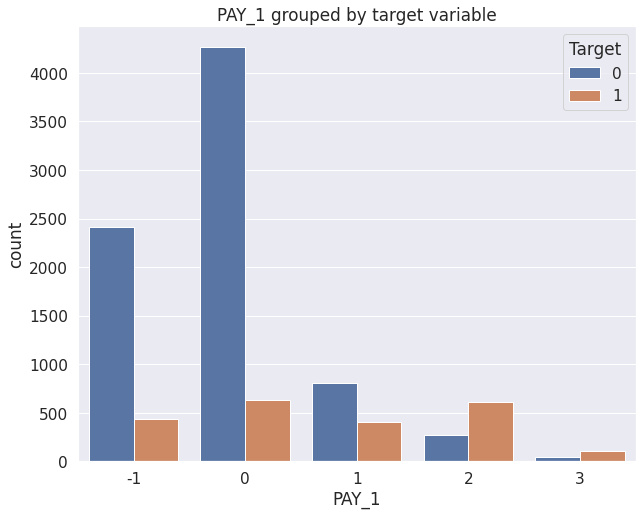

In [734]:
plt.figure(figsize=(10, 8))

sns.countplot(x="PAY_1", hue=TARGET_NAME, data=df)
plt.title('PAY_1 grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

**Наблюдение**

Изучив получившийся график, видно, что значения -1 (погашен полностью) и 0 (погашен частично) признака PAY_1 имеют схожие доли в разрезе целевой переменной. Если это действительно так, то можно будет, например, объединить их в одну категорию.

**Гипотеза** 

* Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы
* Альтернативная гипотеза: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы
* Критерий: Хи-квадрат Пирсона
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

Для проверки данной гипотезы необходимо подать наблюдаемые частоты категорий -1 и 0 признака PAY_1 в выбранный критерий, после чего оценить значение достигаемого уровня значимости p-value и сравнить с его с выбранным порогом альфа, если p-value получится больше выбранного порога, то гипотезу о согласованности частот можно не отбрасывать.

*Сформируем выборку и рассчитаем наблюдаемые частоты*

In [794]:
pay1_and_target_s = df.loc[df['PAY_1'].isin([-1, 0]), ['ID', 'PAY_1', 'NEXT_MONTH_DEFAULT']].sample(1000, random_state=42)

In [795]:
table1 = pay1_and_target_s.pivot_table(values='ID', index='PAY_1', columns='NEXT_MONTH_DEFAULT', aggfunc='count')
table1

NEXT_MONTH_DEFAULT,0,1
PAY_1,,
-1,303,55
0,561,81


In [796]:
chi2, p, dof, expected = chi2_contingency(table1, correction=False)
p

0.22452043839014327

P-value получилось больше выбранного уровня значимости, соответственно у нас нет оснований для отвержения нулевой гипотезы и можно допустить, что категории -1 (погашен полностью) и 0 (погашен частично) одинаково влияют на целевую переменную и их можно объединить в одну категорию.

In [819]:
pay2_and_target_s = df.loc[df['PAY_2'].isin([-1, 0]), ['ID', 'PAY_2', 'NEXT_MONTH_DEFAULT']].sample(1000, random_state=42)

In [820]:
table2 = pay2_and_target_s.pivot_table(values='ID', index='PAY_2', columns='NEXT_MONTH_DEFAULT', aggfunc='count')
table2

NEXT_MONTH_DEFAULT,0,1
PAY_2,,
-1,333,65
0,499,103


In [821]:
chi2, p, dof, expected = chi2_contingency(table2, correction=False)
p

0.747377445333598

P-value получилось больше выбранного уровня значимости, соответственно у нас нет оснований для отвержения нулевой гипотезы и можно допустить, что категории -1 (погашен полностью) и 0 (погашен частично) одинаково влияют на целевую переменную и их можно объединить в одну категорию.

In [822]:
pay3_and_target_s = df.loc[df['PAY_3'].isin([-1, 0]), ['ID', 'PAY_3', 'NEXT_MONTH_DEFAULT']].sample(1000, random_state=42)
table3 = pay3_and_target_s.pivot_table(values='ID', index='PAY_3', columns='NEXT_MONTH_DEFAULT', aggfunc='count')
table3

NEXT_MONTH_DEFAULT,0,1
PAY_3,,
-1,334,61
0,505,100


In [823]:
chi2, p, dof, expected = chi2_contingency(table3, correction=False)
p

0.647859326681655

P-value получилось больше выбранного уровня значимости, соответственно у нас нет оснований для отвержения нулевой гипотезы и можно допустить, что категории -1 (погашен полностью) и 0 (погашен частично) одинаково влияют на целевую переменную и их можно объединить в одну категорию.

In [824]:
pay4_and_target_s = df.loc[df['PAY_4'].isin([-1, 0]), ['ID', 'PAY_4', 'NEXT_MONTH_DEFAULT']].sample(1000, random_state=42)
table4 = pay4_and_target_s.pivot_table(values='ID', index='PAY_4', columns='NEXT_MONTH_DEFAULT', aggfunc='count')
table4

NEXT_MONTH_DEFAULT,0,1
PAY_4,,
-1,307,63
0,517,113


In [825]:
chi2, p, dof, expected = chi2_contingency(table4, correction=False)
p

0.7153923895902732

P-value получилось больше выбранного уровня значимости, соответственно у нас нет оснований для отвержения нулевой гипотезы и можно допустить, что категории -1 (погашен полностью) и 0 (погашен частично) одинаково влияют на целевую переменную и их можно объединить в одну категорию.

In [826]:
pay5_and_target_s = df.loc[df['PAY_5'].isin([-1, 0]), ['ID', 'PAY_5', 'NEXT_MONTH_DEFAULT']].sample(1000, random_state=42)
table5 = pay5_and_target_s.pivot_table(values='ID', index='PAY_5', columns='NEXT_MONTH_DEFAULT', aggfunc='count')
table5

NEXT_MONTH_DEFAULT,0,1
PAY_5,,
-1,301,74
0,521,104


In [827]:
chi2, p, dof, expected = chi2_contingency(table5, correction=False)
p

0.21569935073293162

P-value получилось больше выбранного уровня значимости, соответственно у нас нет оснований для отвержения нулевой гипотезы и можно допустить, что категории -1 (погашен полностью) и 0 (погашен частично) одинаково влияют на целевую переменную и их можно объединить в одну категорию.

In [828]:
pay6_and_target_s = df.loc[df['PAY_6'].isin([-1, 0]), ['ID', 'PAY_6', 'NEXT_MONTH_DEFAULT']].sample(1000, random_state=122)
table6 = pay6_and_target_s.pivot_table(values='ID', index='PAY_6', columns='NEXT_MONTH_DEFAULT', aggfunc='count')
table6

NEXT_MONTH_DEFAULT,0,1
PAY_6,,
-1,329,61
0,492,118


In [829]:
chi2, p, dof, expected = chi2_contingency(table6, correction=False)
p

0.13622935543879905

P-value получилось больше выбранного уровня значимости, соответственно у нас нет оснований для отвержения нулевой гипотезы и можно допустить, что категории -1 (погашен полностью) и 0 (погашен частично) одинаково влияют на целевую переменную и их можно объединить в одну категорию.

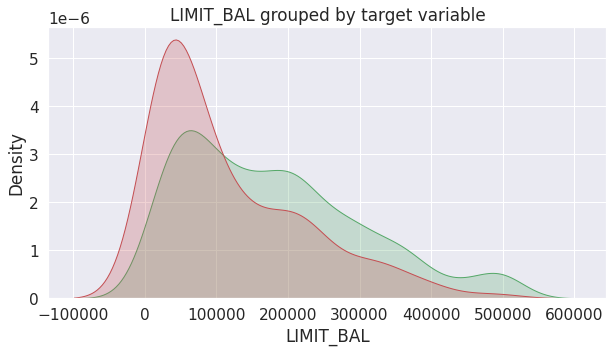

In [814]:
limit_bal_with_target_s = df[['LIMIT_BAL', TARGET_NAME]].sample(1000)
limit_bal_s = limit_bal_with_target_s['LIMIT_BAL']
limit_bal_target_0 = limit_bal_s[limit_bal_with_target_s[TARGET_NAME] == 0]
limit_bal_target_1 = limit_bal_s[limit_bal_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(limit_bal_target_0, shade=True, label='No default', color='g')
sns.kdeplot(limit_bal_target_1, shade=True, label='Default', color='r')

plt.xlabel('LIMIT_BAL')
plt.title('LIMIT_BAL grouped by target variable')
plt.show()

**Наблюдение**

Похоже что две группы, полученные в результате разбиения признака "LIMIT_BAL" по целевой переменной, имеют различные распределения, что может помочь при построение модели, т.к. это будет означать, что между признаком "LIMIT_BAL" и целевой переменной, возможно, существует некоторая функциональная зависимость.

**Гипотеза** 
* Нулевая гипотеза: средние значения в двух независимых выборках равны
* Альтернативная гипотеза: средние значения в двух независимых выборках различаются
* Критерий: критерий Стьюдента (t-тест) и его аналоги
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

Что бы проверить данную гипотезу сравним две выборки из рассматриваемых групп на предмет равенства средних значений.
Если вероятность того, что мат. ожидания в исходных группах равны, при данных выборках, буде менее 5%, то можно будет говорить о том, что скорее всего выборки имеют различные распределения.

In [754]:
shapiro(limit_bal_s)

ShapiroResult(statistic=0.9141244292259216, pvalue=2.399714715910137e-23)

По полученному значению p-value, которое сильно меньше 0.05, можем заключить, что гипотеза о "нормальности" отвергается.

Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график

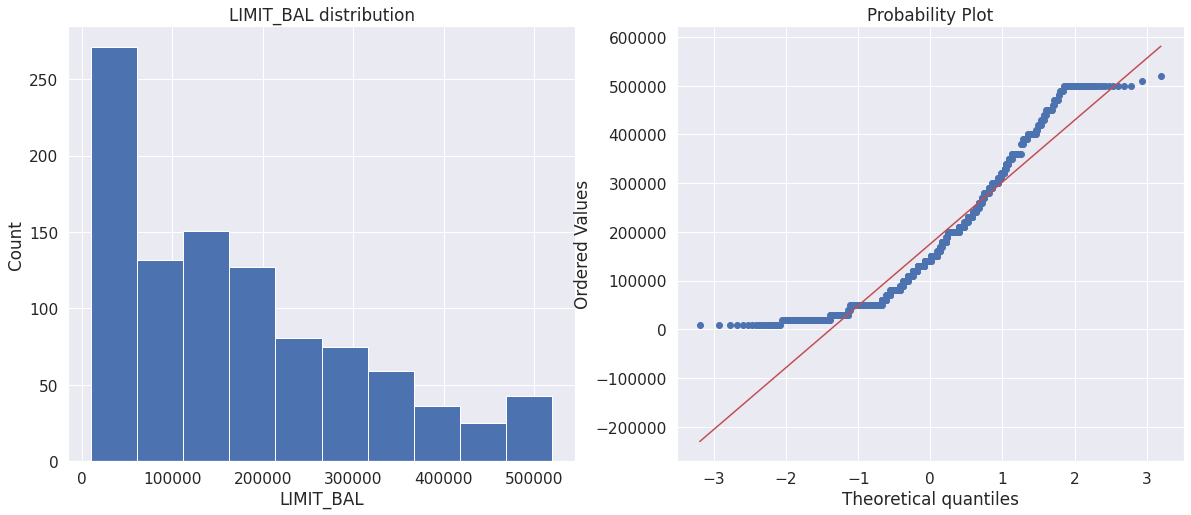

In [755]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('LIMIT_BAL')
ax1.set_ylabel('Count')
ax1.set_title('LIMIT_BAL distribution')
limit_bal_s.hist()

plt.subplot(122)
probplot(limit_bal_s, dist='norm', plot=plt)

plt.show()

Визуальная оценка подтверждает показания критерия Шапиро-Уилка по поводу того, что закон распределения отличный от "нормального", в связи с чем, мы не сможем воспользоваться критерием Стьюдента для проверки гипотезы о равности мат. ожиданий признака LIMIT_BAL в группах с просроченным и непросроченным платежом в следующем месяце, но мы сможем воспользоваться его непараметрическим аналогом - критерием Манна-Уитни, который не требователен к закону распределения.

In [756]:
mannwhitneyu(limit_bal_target_0, limit_bal_target_1)

MannwhitneyuResult(statistic=98750.5, pvalue=4.474200324174528e-07)

Согласно значению p-value, гипотеза о равности мат. ожиданий отвергается, но стоит ради дополнительной проверки обратиться к доверительным интервалам.

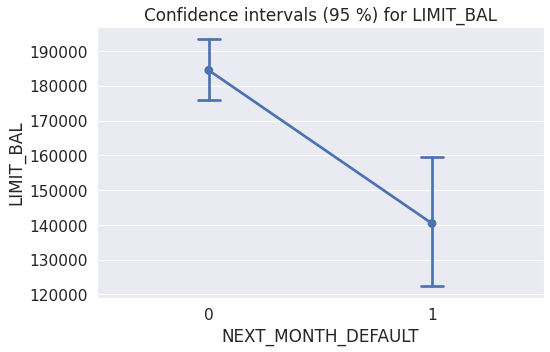

In [757]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='LIMIT_BAL', data=limit_bal_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for LIMIT_BAL')
plt.show()

По данному графику так же видно, что интервалы, в которых с 95% вероятностью должны находится истинные мат. ожидания этих двух групп, не пересекаются, что подтверждает результаты полученные с помощью критерия Манна-Уитни.

Это означает, что группы из которых взяты данные выборки, с допускаемой нами вероятностью (95%), имеют различные распределения и этот признак может быть полезен для определения значения целевой переменной.

### Анализ признакового пространства

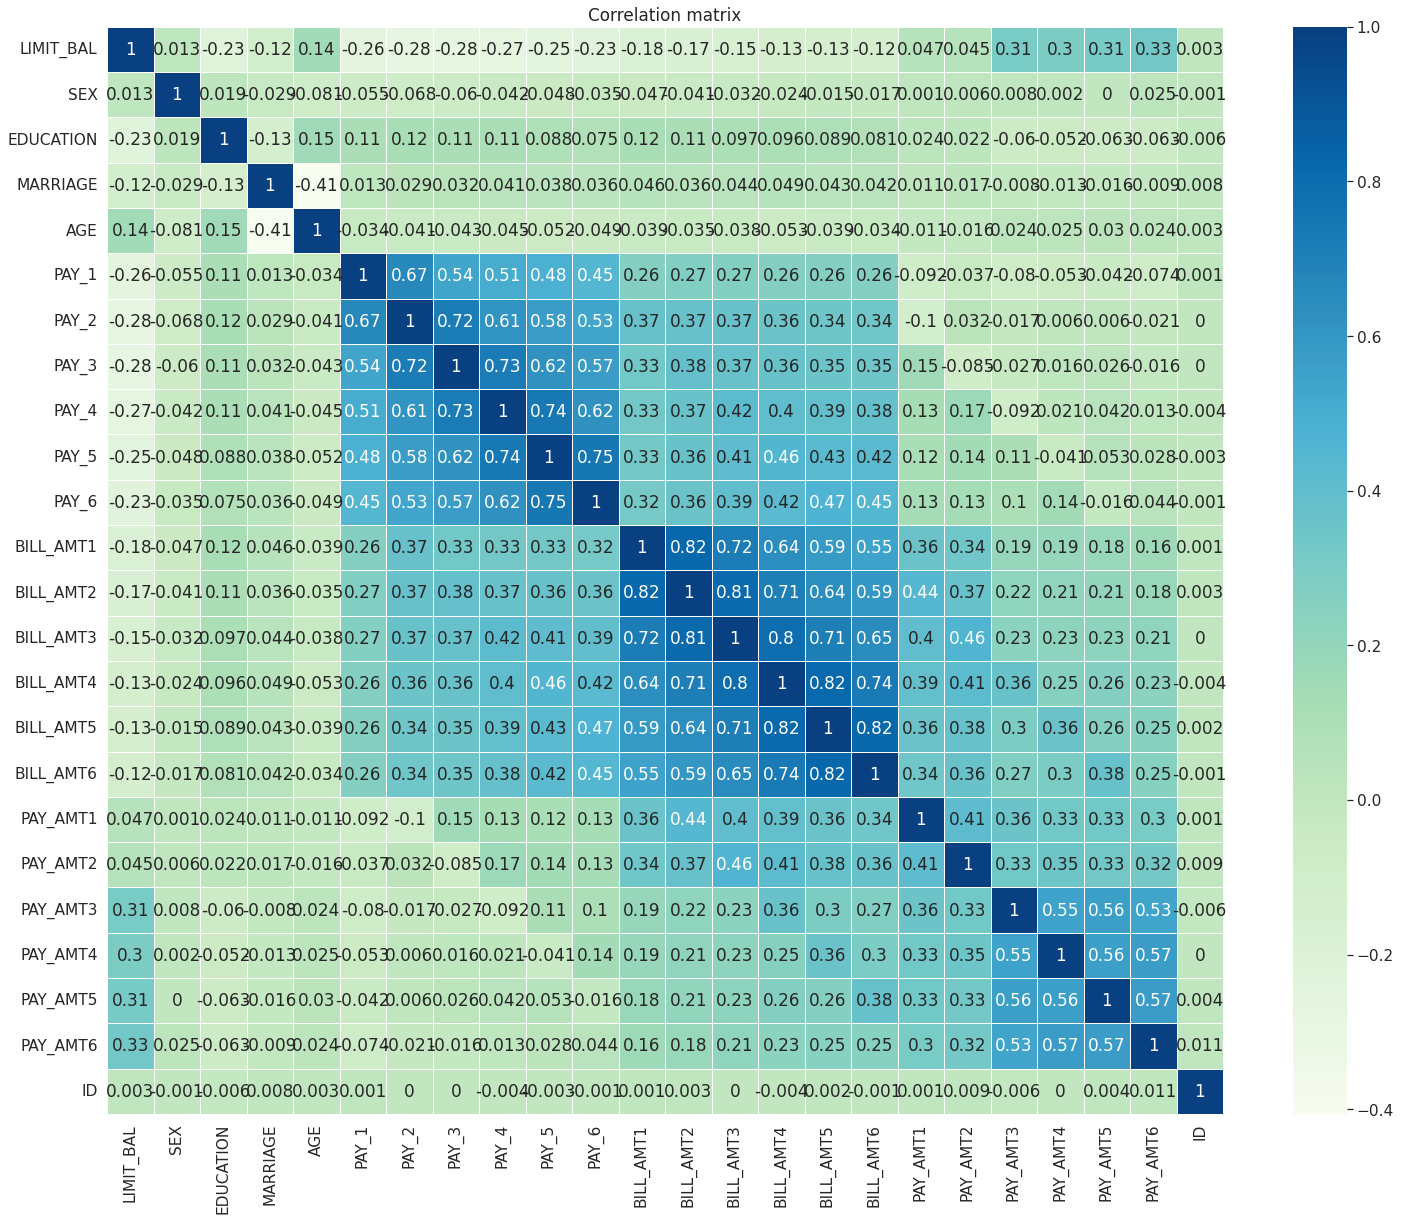

In [758]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(df[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

### Приведение типов данных

In [849]:
for colname in ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']:
    df[colname] = df[colname].astype(str)

#### Dummies

In [851]:
df['IS_MALE'] = df['SEX'].map({'1':'1', '2':'0'}).astype(int)

In [852]:
for cat_colname in df.select_dtypes(include='object').columns[1:]:
    df = pd.concat([df, pd.get_dummies(df[cat_colname], prefix=cat_colname)], axis=1)

In [853]:
df.dtypes

LIMIT_BAL    float64
SEX           object
EDUCATION     object
MARRIAGE      object
AGE            int64
              ...   
PAY_5_3        uint8
PAY_6_-1       uint8
PAY_6_0        uint8
PAY_6_2        uint8
PAY_6_3        uint8
Length: 65, dtype: object

### Отбор признаков

In [ ]:
TARGET_NAME = 'NEXT_MONTH_DEFAULT'
BASE_FEATURE_NAMES = df_base.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME, 'ID'] + BASE_FEATURE_NAMES).tolist()

In [878]:
NUM_FEATURE_NAMES = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                     'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

CAT_FEATURE_NAMES = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

#SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + NEW_FEATURE_NAMES